In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [4]:
# Load dataset
df = pd.read_csv("train.csv")

In [5]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    int64  
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(2), object(7)
memory usage: 25.3+ KB


In [7]:
df.describe()

,sl_no,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,0.353488,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,0.479168,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,0.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,0.000000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,0.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,1.000000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,1.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [8]:
df.drop(['sl_no', 'salary'], axis=1, inplace=True)

Dataset Overview:


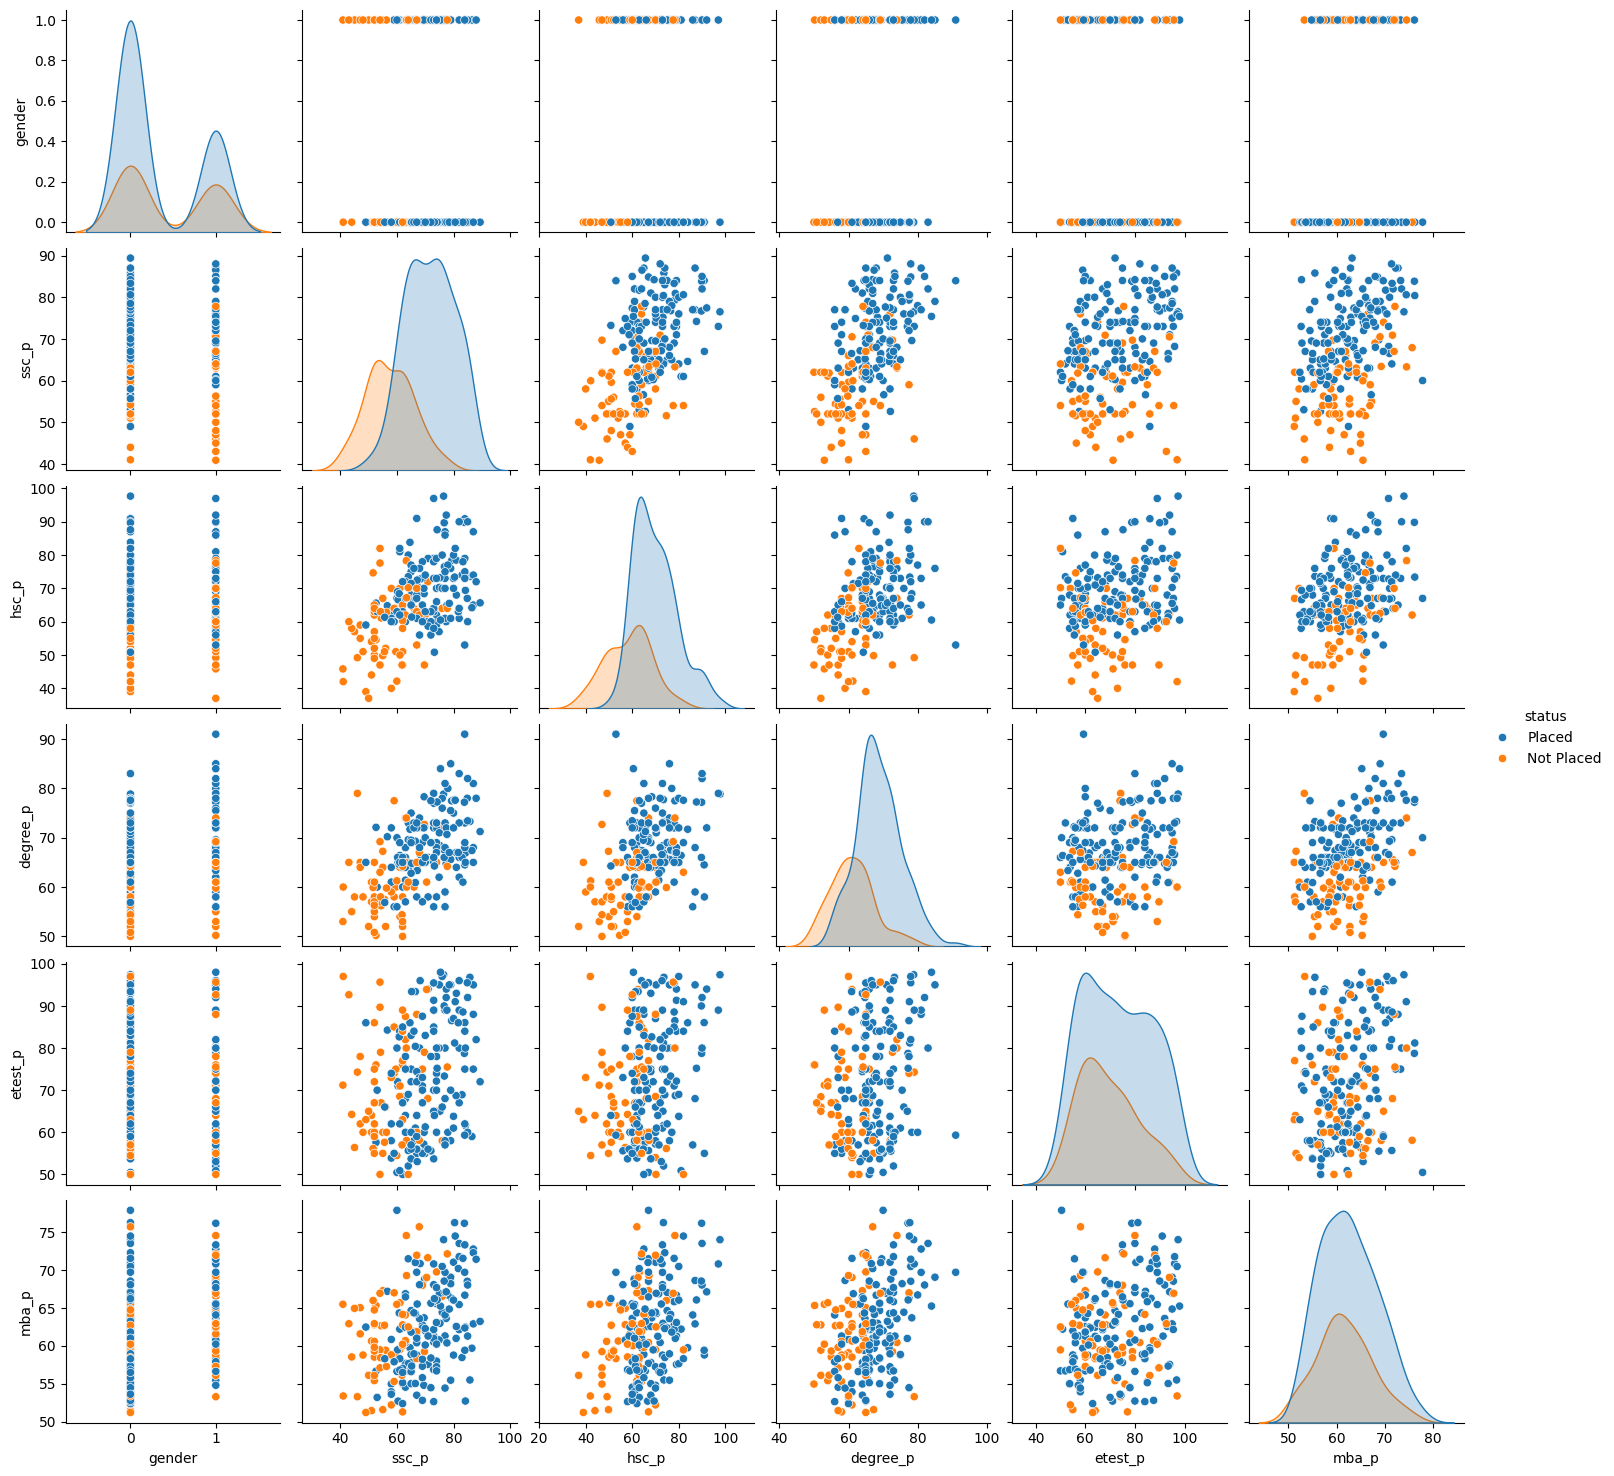

In [9]:
print("Dataset Overview:")
sns.pairplot(df, hue='status')
plt.show()

In [10]:
# Encode categorical variables
label_encoders = {}
for col in ['ssc_b', 'hsc_b', 'workex', 'status']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['hsc_s', 'degree_t', 'specialisation'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  215 non-null    int64  
 1   ssc_p                   215 non-null    float64
 2   ssc_b                   215 non-null    int32  
 3   hsc_p                   215 non-null    float64
 4   hsc_b                   215 non-null    int32  
 5   degree_p                215 non-null    float64
 6   workex                  215 non-null    int32  
 7   etest_p                 215 non-null    float64
 8   mba_p                   215 non-null    float64
 9   status                  215 non-null    int32  
 10  hsc_s_Arts              215 non-null    bool   
 11  hsc_s_Commerce          215 non-null    bool   
 12  hsc_s_Science           215 non-null    bool   
 13  degree_t_Comm&Mgmt      215 non-null    bool   
 14  degree_t_Others         215 non-null    bo

In [11]:
# Feature-target split
X = df.drop(columns=['status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Naïve Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [14]:
# Train and evaluate models
results = {}
plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }
    
    print(f"\n{name} Model Evaluation:")
    print("Accuracy:", results[name]['accuracy'])
    print("Precision:", results[name]['precision'])
    print("Recall:", results[name]['recall'])
    print("F1-Score:", results[name]['f1_score'])
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\91892\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Evaluation:
Accuracy: 0.8153846153846154
Precision: 0.82
Recall: 0.9318181818181818
F1-Score: 0.8723404255319149
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67        21
           1       0.82      0.93      0.87        44

    accuracy                           0.82        65
   macro avg       0.81      0.75      0.77        65
weighted avg       0.81      0.82      0.81        65

Confusion Matrix:
 [[12  9]
 [ 3 41]]

Naïve Bayes Model Evaluation:
Accuracy: 0.7230769230769231
Precision: 0.75
Recall: 0.8863636363636364
F1-Score: 0.8125
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.75      0.89      0.81        44

    accuracy                           0.72        65
   macro avg       0.68      0.63      0.64        65
weighted avg       0.71      0.72      0.70        65

Confusion Ma

<Figure size 1000x600 with 0 Axes>

In [15]:
# Implement Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

voting_results = {
    "accuracy": accuracy_score(y_test, y_pred_voting),
    "precision": precision_score(y_test, y_pred_voting),
    "recall": recall_score(y_test, y_pred_voting),
    "f1_score": f1_score(y_test, y_pred_voting)
}

print("\nVoting Classifier Evaluation:")
print("Accuracy:", voting_results['accuracy'])
print("Precision:", voting_results['precision'])
print("Recall:", voting_results['recall'])
print("F1-Score:", voting_results['f1_score'])
print("Classification Report:\n", classification_report(y_test, y_pred_voting))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))


Voting Classifier Evaluation:
Accuracy: 0.7538461538461538
Precision: 0.7692307692307693
Recall: 0.9090909090909091
F1-Score: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.43      0.53        21
           1       0.77      0.91      0.83        44

    accuracy                           0.75        65
   macro avg       0.73      0.67      0.68        65
weighted avg       0.74      0.75      0.74        65

Confusion Matrix:
 [[ 9 12]
 [ 4 40]]


c:\Users\91892\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


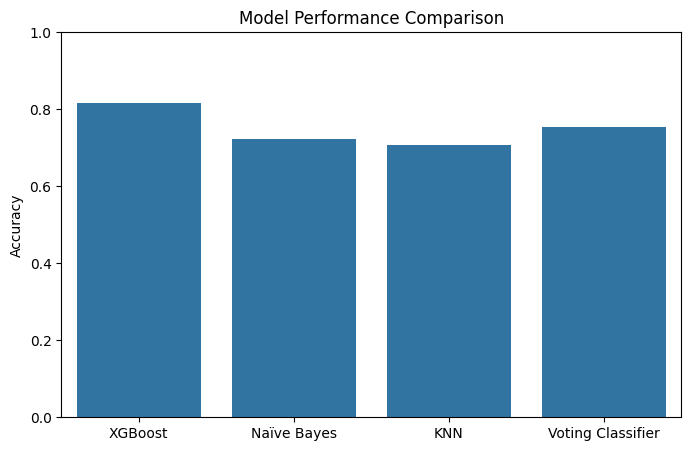

In [16]:
# Model comparison visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()) + ["Voting Classifier"], 
            y=[res["accuracy"] for res in results.values()] + [voting_results["accuracy"]])
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()
